<a href="https://colab.research.google.com/github/fun-debug/demo/blob/main/d2l/attention-mechanisms/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l matplotlib-inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:

In [2]:
!pip install matplotlib==3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.0.0-cp38-cp38-linux_x86_64.whl size=11844622 sha256=de4a458d72a624a38495a9fee17b4e5bb0e7906caa74873e115c3c704ca3c0b9
  Stored in directory: /root/.cache/pip/wheels/a9/1e/ed/3e09c67472517aa5d81f8c15de6c81162d249ebe442e4f3007
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires matplotlib!=3.0.0,>=2.0.2, but you have matplotlib 3.0.0 which is incompatible.
scikit-image 0.18.3 req

In [3]:
import math
import torch
import pandas as pd
from torch import nn
from d2l import torch as d2l

In [4]:
class PositionWiseFFN(nn.Module):
  def __init__(self,ffn_num_input,ffn_num_hiddens,ffn_num_outputs,**kwargs):
    super(PositionWiseFFN,self).__init__(**kwargs)
    self.dense1=nn.Linear(ffn_num_input,ffn_num_hiddens)
    self.relu=nn.ReLU()
    self.dense2=nn.Linear(ffn_num_hiddens,ffn_num_outputs)
  def forward(self,X):
    return self.dense2(self.relu(self.dense1(X)))

In [5]:
!nvidia-smi

Mon Feb 20 14:08:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
ffn=PositionWiseFFN(4,4,8)
ffn.eval()
ffn(torch.ones((2,3,4)))[0]

tensor([[ 0.2268,  0.2339,  0.4670, -0.1192,  0.7869,  0.6534,  0.2512,  0.2166],
        [ 0.2268,  0.2339,  0.4670, -0.1192,  0.7869,  0.6534,  0.2512,  0.2166],
        [ 0.2268,  0.2339,  0.4670, -0.1192,  0.7869,  0.6534,  0.2512,  0.2166]],
       grad_fn=<SelectBackward0>)

In [7]:
ln=nn.LayerNorm(2)
bn=nn.BatchNorm1d(2)
X=torch.tensor([[1,2],[2,3]],dtype=torch.float32)
print('layer norm:',ln(X),'\nbatch norm:',bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [8]:
class AddNorm(nn.Module):
  def __init__(self,normalized_shape,dropout,**kwargs):
    super(AddNorm,self).__init__(**kwargs)
    self.dropout=nn.Dropout(dropout)
    self.ln=nn.LayerNorm(normalized_shape)
  def forward(self,X,Y):
    return self.ln(self.dropout(Y)+X)

In [9]:
add_norm=AddNorm([3,4],0.5)
add_norm.eval()
add_norm(torch.ones((2,3,4)),torch.ones((2,3,4))).shape

torch.Size([2, 3, 4])

In [10]:
class EncoderBlock(nn.Module):
  def __init__(self,key_size,query_size,value_size,num_hiddens,norm_shape,ffn_num_input,
               ffn_num_hiddens,num_heads,dropout,use_bias=False,**kwargs):
    super(EncoderBlock,self).__init__(**kwargs)
    self.attention=d2l.MultiHeadAttention(
        key_size,query_size,value_size,num_hiddens,num_heads,dropout,use_bias
    )
    self.addnorm1=AddNorm(norm_shape,dropout)
    self.ffn=PositionWiseFFN(
        ffn_num_input,ffn_num_hiddens,num_hiddens
    )
    self.addnorm2=AddNorm(norm_shape,dropout)
  def forward(self,X,valid_lens):
    Y=self.addnorm1(X,self.attention(X,X,X,valid_lens))
    return self.addnorm2(Y,self.ffn(Y))

In [11]:
X=torch.ones((2,100,24))
valid_lens=torch.tensor([3,2])
encoder_blk=EncoderBlock(24,24,24,24,[100,24],24,48,8,0.5)
encoder_blk.eval()
encoder_blk(X,valid_lens).shape

torch.Size([2, 100, 24])

In [12]:
class TransformerEncoder(d2l.Encoder):
  def __init__(self,vocab_size, key_size, query_size, value_size,
               num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
               num_heads, num_layers, dropout, use_bias=False, **kwargs):
    super(TransformerEncoder,self).__init__(**kwargs)
    self.num_hiddens=num_hiddens
    self.embedding=nn.Embedding(vocab_size,num_hiddens)
    self.pos_encoding=d2l.PositionalEncoding(num_hiddens,dropout)
    self.blks=nn.Sequential()
    for i in range(num_layers):
      self.blks.add_module("block"+str(i),EncoderBlock(key_size,query_size,value_size,
                                                       num_hiddens,norm_shape,ffn_num_input,
                                                       ffn_num_hiddens,num_heads,dropout,use_bias))
  def forward(self,X,valid_lens,*args):
    X=self.pos_encoding(self.embedding(X)*math.sqrt(self.num_hiddens))
    self.attention_weights=[None] *len(self.blks)
    for i,blk in enumerate(self.blks):
      X=blk(X,valid_lens)
      self.attention_weights[
          i
      ]=blk.attention.attention.attention_weights
    return X

In [13]:
encoder=TransformerEncoder(
    200,24,24,24,24,[100,24],24,48,8,2,0.5
)
encoder.eval()
encoder(torch.ones((2,100),dtype=torch.long),valid_lens).shape

torch.Size([2, 100, 24])

In [25]:
class DecoderBlock(nn.Module):
  def __init__(self,key_size, query_size, value_size, num_hiddens,
               norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
               dropout, i, **kwargs):
    super(DecoderBlock,self).__init__(**kwargs)
    self.i=i
    self.attention1=d2l.MultiHeadAttention(key_size,query_size,value_size,num_hiddens,num_heads,dropout)
    self.addnorm1=AddNorm(norm_shape,dropout)
    self.attention2=d2l.MultiHeadAttention(
        key_size,query_size,value_size,num_hiddens,num_heads,dropout
    )
    self.addnorm2=AddNorm(norm_shape,dropout)
    self.ffn=PositionWiseFFN(ffn_num_input,ffn_num_hiddens,num_hiddens)
    self.addnorm3=AddNorm(norm_shape,dropout)
  def forward(self,X,state):
    enc_outputs,enc_valid_lens=state[0],state[1]
    # 训练阶段，输出序列的所有词元都在同一时间处理，
    # 因此state[2][self.i]初始化为None。
    # 预测阶段，输出序列是通过词元一个接着一个解码的，
    # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
    if state[2][self.i] is None:
      key_values=X
    else:
      key_values=torch.cat((state[2][self.i],X),axis=1)
    state[2][self.i]=key_values
    if self.training:
      batch_size,num_steps,_ =X.shape
      dec_valid_lens=torch.arange(
          1,num_steps+1,device=X.device
      ).repeat(batch_size,1)
    else:
      dec_valid_lens=None
    X2=self.attention1(X,key_values,key_values,dec_valid_lens)
    Y=self.addnorm1(X,X2)
    Y2=self.attention2(Y,enc_outputs,enc_outputs,enc_valid_lens)
    Z=self.addnorm2(Y,Y2)
    return self.addnorm3(Z,self.ffn(Z)),state

In [26]:
decoder_blk=DecoderBlock(24,24,24,24,[100,24],24,48,8,0.5,0)
decoder_blk.eval()
X=torch.ones((2,100,24))
state=[encoder_blk(X,valid_lens),valid_lens,[None]]
decoder_blk(X,state)[0].shape

torch.Size([2, 100, 24])

In [27]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.031, 6969.9 tokens/sec on cuda:0


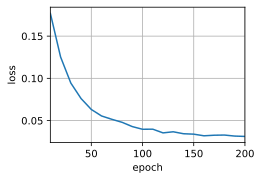

In [28]:
num_hiddens,num_layers,dropout,batch_size,num_steps=32,2,0.1,64,10
lr,num_epochs,device=0.005,200,d2l.try_gpu()
ffn_num_input,ffn_num_hiddens,num_heads=32,64,4
key_size,query_size,value_size=32,32,32
norm_shape=[32]
train_iter,src_vocab,tgt_vocab=d2l.load_data_nmt(batch_size,num_steps)
encoder=TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout
)
decoder=TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout
)
net=d2l.EncoderDecoder(encoder,decoder)
d2l.train_seq2seq(net,train_iter,lr,num_epochs,tgt_vocab,device)